# Introduction

1. The standard practice for clustering image data is Getting the features from the images: Using the raw pixels as features will give you poor results. Pass the images through a pre trained CNN(VGG16 in this case). Then use the last CNN layer(just before the fully connected) as the image features extractor, which in VGG16 should have size (1, 7, 7, 512).

2. Clustering of features : Having got the rich features for each image, you can do clustering on these(like K-means).

The steps will be implemented in keras with the VGG16 neural network and sklearn, respectively, and visualised with seaborn. This section will be divided into 4 sections.

#### Import proper libraries

In [5]:
%matplotlib inline
import numpy as np
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os as os
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from scipy.spatial import distance
from keras import backend as K
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics

## Implementation:

The standard practice for clustering image data is 

1. Getting the features from the images: Using the raw pixels as features will give you poor results. Thus, we will pass the images through a pre trained CNN(VGG16 in this case). Then use the last CNN layer(just before the fully connected) as the image features extractor, which in VGG16 should have size (1, 7, 7, 512).

2. Clustering of features : Having got the rich features for each image, you can do clustering on these(like K-means).

The steps will be implemented in keras with the VGG16 neural network and sklearn, respectively, and visualised with seaborn. This section will be divided into 4 sections.

### Feature Extraction and Neural Network layers

The model that we chose for this clustering job was the VGG16 model (https://arxiv.org/abs/1409.1556)). This layer had 16-19 weight layers and achieved first and second place in the IMAGENET competition in 2015 and thus was used for this problem. We first imported a keras interpretation and then checked the model summary to get a good idea of the neural network's weight layers. There were alternatives, including ResNet. However, training and predcting with individual nets is memory heavy, and due to hardware limitations we ended up choosing the VGG16.VGG16 works by extracting features from the image with the last max pooling layer. These features are then used to cluster the images. 

Here is a link to the architecture. https://www.researchgate.net/figure/A-visualization-of-the-VGG-architecture_fig2_318701491


An alternative was to handcraft a neural network and train it, but due to the accuracy of the VGG16 in image clustering and my hardware's memory constraints and other limitations, I chose the pre-trained neural network.

#### Check model architecture


In [2]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

#### Model Testing

To test the model and ensure that it is working properly, I decided to test it on Bulbasaur (image 1). The features are of the shape (1, 7, 7, 512) which matches the expected output of the neural network.

In [6]:
# Testing on 1 image
os.chdir('Downloads')
img_path = 'pokemon/1.png'

img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg16_feature = model.predict(img_data)

print(vgg16_feature.shape)

(1, 7, 7, 512)


#### Feature Extraction

Afterwards, I extracted all of the features of all the images and stored them in a list, converted them into an array, and then appended a flattened array into the list. I used the flatten function to collapse a feature of the model into the 1-d array that can be fed as an input to sklearn clustering function. I also printed the filename which corresponded to each feature array.

In [7]:
# Create the feature list 
vgg16_feature_list = []

directory = 'pokemon'
for filename in os.listdir('pokemon'):
    if filename.endswith(".png"):
        print(filename)
        input_path = os.path.join(directory, filename)
        img = image.load_img(input_path, target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        vgg16_feature = model.predict(img_data)
        vgg16_feature_np = np.array(vgg16_feature)
        print(vgg16_feature_np.flatten())
        vgg16_feature_list.append(vgg16_feature_np.flatten())

vgg16_feature_list_np = np.array(vgg16_feature_list)

1.png
[-0. -0. -0. ... -0. -0. -0.]
10.png
[-0.       -0.       -0.       ... -0.       11.122283 -0.      ]
100.png
[-0.         -0.         -0.         ...  0.07930136 15.41279
 -0.        ]
101.png
[-0.       -0.       -0.       ... -0.       14.439815 -0.      ]
102.png
[-0.         -0.         -0.         ... -0.          0.86984783
 -0.        ]
103.png
[-0.        -0.        -0.        ... -0.         2.3410358 -0.       ]
104.png
[-0.        -0.        -0.        ... -0.         1.1902089 -0.       ]
105.png
[-0.        -0.        -0.        ... -0.         1.0067176 -0.       ]
106.png
[-0. -0. -0. ... -0. -0. -0.]
107.png
[-0. -0. -0. ... -0. -0. -0.]
108.png
[-0.       -0.       -0.       ... -0.       -0.        5.830925]
109.png
[-0.        -0.        -0.        ... -0.         5.0752716 -0.       ]
11.png
[-0.       -0.       -0.       ... -0.       10.672209 -0.      ]
110.png
[-0.        -0.        -0.        ... -0.         2.3978016 -0.       ]
111.png
[-0.        -0.

[-0. -0. -0. ... -0. -0. -0.]
206.png
[-0. -0. -0. ... -0. -0. -0.]
207.png
[-0.       -0.       36.317715 ... -0.       -0.       -0.      ]
208-mega.png
[-0. -0. -0. ... -0. -0. -0.]
208.png
[-0.        -0.        -0.        ... -0.         7.1711435 -0.       ]
209.png
[-0. -0. -0. ... -0. -0. -0.]
21.png
[-0.        -0.        -0.        ... -0.        11.146109   0.5427466]
210.png
[-0.        -0.        -0.        ... -0.         0.4574194 -0.       ]
211.png
[-0. -0. -0. ... -0. -0. -0.]
212-mega.png
[-0.        -0.        -0.        ... -0.         2.5393345 -0.       ]
212.png
[-0. -0. -0. ... -0. -0. -0.]
213.png
[-0. -0. -0. ... -0. -0. -0.]
214-mega.png
[-0. -0. -0. ... -0. -0. -0.]
214.png
[-0.        -0.        -0.        ... -0.        21.627542   4.4315495]
215.png
[-0.        -0.        20.433905  ... -0.         1.8258775 -0.       ]
216.png
[-0.       -0.       -0.       ... -0.        8.086959 -0.      ]
217.png
[-0.        -0.        -0.        ... -0.        -0.  

[-0.        -0.        -0.        ... -0.         1.0430139 -0.       ]
310.png
[-0. -0. -0. ... -0. -0. -0.]
311.png
[-0. -0. -0. ... -0. -0. -0.]
312.png
[-0. -0. -0. ... -0. -0. -0.]
313.png
[-0.       -0.       -0.       ... -0.        0.830196 -0.      ]
314.png
[-0. -0. -0. ... -0. -0. -0.]
315.png
[-0. -0. -0. ... -0. -0. -0.]
316.png
[-0. -0. -0. ... -0. -0. -0.]
317.png
[-0. -0. -0. ... -0. -0. -0.]
318.png
[-0. -0. -0. ... -0. -0. -0.]
319-mega.png
[-0. -0. -0. ... -0. -0. -0.]
319.png
[-0. -0. -0. ... -0. -0. -0.]
32.png
[-0. -0. -0. ... -0. -0. -0.]
320.png
[-0.         -0.         -0.         ... -0.          0.15119734
 -0.        ]
321.png
[-0.         -0.         -0.         ... -0.          0.05317324
 -0.        ]
322.png
[-0. -0. -0. ... -0. -0. -0.]
323-mega.png
[-0. -0. -0. ... -0. -0. -0.]
323.png
[-0. -0. -0. ... -0. -0. -0.]
324.png
[-0. -0. -0. ... -0. -0. -0.]
325.png
[-0. -0. -0. ... -0. -0. -0.]
326.png
[-0.        -0.        -0.        ... -0.         3.886

[-0. -0. -0. ... -0. -0. -0.]
413-sandy.png
[-0. -0. -0. ... -0. -0. -0.]
413-trash.png
[-0. -0. -0. ... -0. -0. -0.]
414.png
[-0. -0. -0. ... -0. -0. -0.]
415.png
[-0. -0. -0. ... -0. -0. -0.]
416.png
[-0. -0. -0. ... -0. -0. -0.]
417.png
[-0. -0. -0. ... -0. -0. -0.]
418.png
[-0.        -0.        -0.        ... -0.         2.4641564 -0.       ]
419.png
[-0.        -0.        -0.        ... -0.         0.0045236 -0.       ]
42.png
[-0. -0. -0. ... -0. -0. -0.]
420.png
[-0.       -0.       -0.       ... -0.        1.741299 -0.      ]
421-overcast.png
[-0. -0. -0. ... -0. -0. -0.]
421-sunshine.png
[-0.        -0.        -0.        ... -0.         4.6187916 -0.       ]
422-east.png
[-0.       -0.       -0.       ... -0.        6.409794 -0.      ]
422-west.png
[-0.       -0.       -0.       ... -0.        9.279636 -0.      ]
423-east.png
[-0. -0. -0. ... -0. -0. -0.]
423-west.png
[-0. -0. -0. ... -0. -0. -0.]
424.png
[-0.        -0.        -0.        ... -0.         1.3957341 -0.       ]

[-0.        -0.         3.7519348 ... -0.        -0.        -0.       ]
521.png
[-0. -0. -0. ... -0. -0. -0.]
521f.png
[-0. -0. -0. ... -0. -0. -0.]
522.png
[-0. -0. -0. ... -0. -0. -0.]
523.png
[-0.        -0.        23.021416  ... -0.        -0.         3.6575441]
524.png
[-0. -0. -0. ... -0. -0. -0.]
525.png
[-0. -0. -0. ... -0. -0. -0.]
526.png
[-0.      -0.      -0.      ... -0.       6.99844 -0.     ]
527.png
[-0. -0. -0. ... -0. -0. -0.]
528.png
[-0.         -0.         -0.         ... -0.          0.09516335
 -0.        ]
529.png
[ 7.3498073 -0.        -0.        ... -0.        -0.        -0.       ]
53.png
[-0.        -0.        -0.        ... -0.         7.6928387  2.149457 ]
530.png
[-0.        -0.        -0.        ... -0.         1.2712526 -0.       ]
531-mega.png
[-0.         -0.         -0.         ... -0.          0.97778374
 -0.        ]
531.png
[-0. -0. -0. ... -0. -0. -0.]
532.png
[-0. -0. -0. ... -0. -0. -0.]
533.png
[-0. -0. -0. ... -0. -0. -0.]
534.png
[-0.       

[-0.        -0.        -0.        ... -0.         1.2823082 -0.       ]
631.png
[-0.       -0.       -0.       ... -0.       -0.        6.452036]
632.png
[-0.       -0.       -0.       ... -0.        3.426701 -0.      ]
633.png
[-0. -0. -0. ... -0. -0. -0.]
634.png
[-0.        -0.        -0.        ... -0.         1.9670671 -0.       ]
635.png
[-0.       -0.       16.228758 ... -0.       -0.       -0.      ]
636.png
[-0.        -0.        -0.        ... -0.         4.2814555 -0.       ]
637.png
[-0.        -0.        -0.        ... -0.         1.9188572 -0.       ]
638.png
[-0. -0. -0. ... -0. -0. -0.]
639.png
[-0. -0. -0. ... -0. -0. -0.]
64.png
[-0.       -0.       -0.       ... -0.       17.095243 -0.      ]
640.png
[-0. -0. -0. ... -0. -0. -0.]
641-incarnate.png
[-0.        -0.        -0.        ... -0.         1.0787939 -0.       ]
641-therian.png
[-0.      -0.      12.51459 ... -0.      -0.      -0.     ]
642-incarnate.png
[-0.        -0.        -0.        ... -0.         4.70181

[-0. -0. -0. ... -0. -0. -0.]
79.png
[-0. -0. -0. ... -0. -0. -0.]
8.png
[-0.       -0.       -0.       ... -0.       12.041213 -0.      ]
80-mega.png
[-0.        -0.        -0.        ... -0.         0.3366636 -0.       ]
80.png
[-0.        -0.        -0.        ... -0.         0.8361543 -0.       ]
81.png
[-0. -0. -0. ... -0. -0. -0.]
82.png
[-0.         -0.         -0.         ... -0.          0.15654671
  0.20974515]
83.png
[-0.       -0.       -0.       ... -0.       -0.        6.383055]
84.png
[-0.         -0.         -0.         ... -0.          0.44599384
 -0.        ]
85.png
[-0.         -0.         -0.         ... -0.          0.06229763
  4.0183115 ]
86.png
[-0. -0. -0. ... -0. -0. -0.]
87.png
[-0.       -0.       -0.       ... -0.       11.221289  8.023524]
88.png
[-0.        -0.        -0.        ... -0.         3.16876    1.5558662]
89.png
[-0. -0. -0. ... -0. -0. -0.]
9-mega.png
[-0.       -0.       -0.       ... -0.        4.452705 -0.      ]
9.png
[-0.        -0.      

### Clustering

The k-means algorithm was chosen here due to its ubiquity and reliability. In addition, visualising high dimensional data is more efficient with the kmeans algorithm than with the other clustering algorithms due to the distance calculations and the ability to efficiently plot the cluster centers. Next, I had to determine a suitable number of clusters. This was chosen via the silhouette_score, which is a calculation that uses the mean intra-cluster distance and the mean nearest-cluster distance for each sample. Unfortunately, the results had shown that even though 2 clusters is the optimal number of clusters, the value is 0.134, which indicates that the clusters are located fairly close to each other. We also printed the labels for each cluster and the cluster centers as well.  

#### Initiating Clustering


In [9]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(vgg16_feature_list_np)

#### Updating the Scores

In [10]:
# Print the score and the cluster
print(metrics.silhouette_score(vgg16_feature_list_np, kmeans.labels_, metric='euclidean'))
print(kmeans.cluster_centers_)

0.0134146195
[[1.6118033e-02 1.1350494e-09 9.1020441e-01 ... 8.0823883e-02
  2.2790022e+00 4.9421167e-01]
 [3.1664968e-08 1.0001314e-03 8.8748950e-01 ... 3.5441931e-02
  1.7875271e+00 4.5373547e-01]]


### 3.3: Visualisation

Unfortunately, visualising multidimensional data has always been a challenge, especially for 819 data arrays that have 25088 elements. However, there are some ways around this, with the most common one being visualising the difference between the feature array and the cluster center, using the appropiate distance function, which gives a good indicator of how far each cluster is away from each other and thus a good measure of the accuracy of the clustering method. I decided that the best way to accomplish the distance visualisation would be to plot the cosine similarity to cluster 2 vs the cosine similarity of the features to for each feature, as the closer the similarity, the more likely the feature array is correctly and clearly labeled. 

#### Create arrays of cosine similarities between each cluster center

In [11]:
cosine_cluster1 = []
cosine_cluster2 = []
for i, array in enumerate(vgg16_feature_list_np):
    a = vgg16_feature_list_np[i]
    b = kmeans.cluster_centers_[0]
    c = kmeans.cluster_centers_[1]
    cosine_1 = distance.cosine(a,b)
    cosine_cluster1.append(cosine_1)
    cosine_2 = distance.cosine(a,c)
    cosine_cluster2.append(cosine_2)

#### Create dataframe (sns input)

In [12]:
Cosine_Similarity = pd.DataFrame(
    {'cluster1_similarity': cosine_cluster1,
     'cluster2_similarity': cosine_cluster2,
     'labels': kmeans.labels_
    })

# Sanity Check
Cosine_Similarity.head(5)

,cluster1_similarity,cluster2_similarity,labels
0,0.539180,0.557608,0
1,0.509857,0.621934,0
2,0.572873,0.611364,0
3,0.636787,0.690067,0
4,0.511696,0.551202,0


#### Plotting the Graph

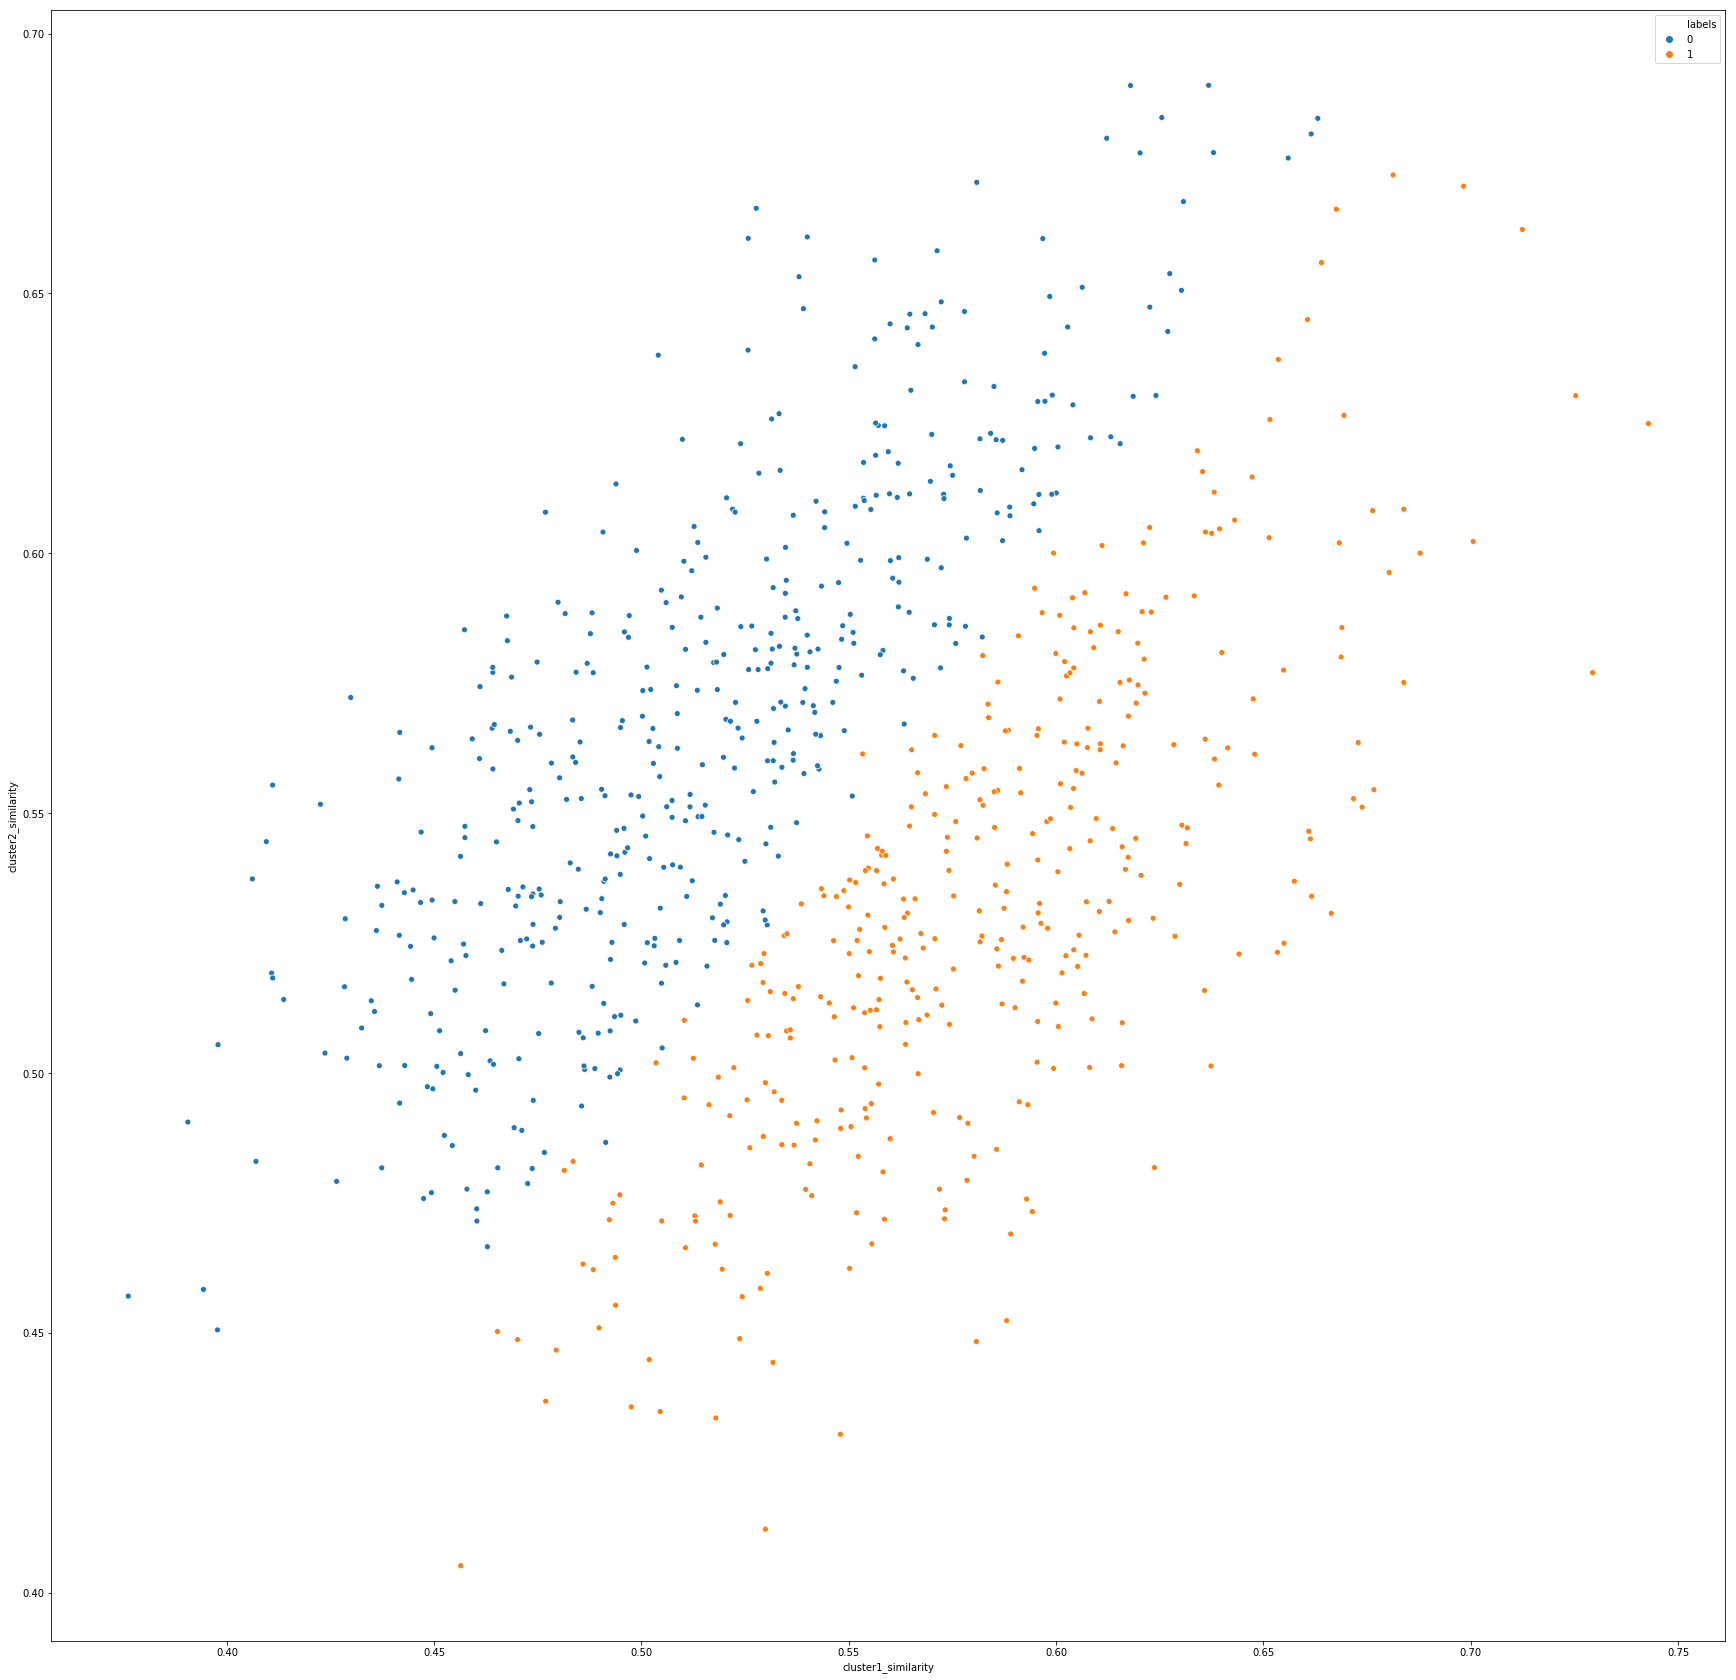

In [13]:
plt.figure(figsize=(30,30))
g = sns.scatterplot(x="cluster1_similarity", y="cluster2_similarity", hue="labels", data=Cosine_Similarity)

As we can see, while there are two different clusters, they are located very close to each other and there is some overlap between each cluster, which means that performance could still be improved. Suggestions for improvement will be explored in the next section.

### Part 3.4: Discussion

The low silhouette score is probably due to the type of training data and is very well reflected by the closely located clusters in the graph. While the model was trained on a wide variety of images like animals, fungi, and everyday objects, none of pictures included Pokemon, meaning that the model didn't have a good reference when it was clustering the current data, providing one explanation for the poor clustering. The low silhouette score can also be explained by the pre-processing of the training data. Thus, to improve clustering more complex methods for pre-processing images could be explored and more representative training data could be used. In addition, with better hardware, further experimentation using different neural network architectures could be explored as well. 